In [1]:
# Running checks for the correct dependencies
import qiskit
from packaging import version
from qiskit_dynamics.solvers import Solver
import numpy as np
import pandas as pd
import scipy.io
import scipy as sp
import matplotlib.pyplot as plt
import math
import numpy.linalg as la
import qiskit_dynamics
from scipy.optimize import leastsq
import networkx as nx
from qiskit.quantum_info import Operator
from qiskit.quantum_info.states import Statevector

In [2]:
def power_iteration(A, num_iterations: int):
    # Ideally choose a random vector
    # To decrease the chance that our vector
    # Is orthogonal to the eigenvector
    b_k = np.random.rand(A.shape[1])
    for _ in range(num_iterations):
        # calculate the matrix-by-vector product Ab
        b_k1 = np.dot(A, b_k)
        # calculate the norm
        b_k1_norm = np.linalg.norm(b_k1)
        # re normalize the vector
        b_k = b_k1 / b_k1_norm
    return b_k

def svd_power(X, num_itr):
    A = X.T @ X
    N = A.shape[0]
    mu = np.zeros(N)
    V = np.zeros_like(A)
    
    for i in range(0, N):
        bk = power_iteration(A, num_itr)
        bk = bk.reshape(bk.shape[0],1)
        muk = ((bk.T @ A @ bk) / (bk.T @ bk)).squeeze()
        mu[i] = muk
        #print(muk)
        tempA = A-muk*np.eye(N)
        #print(tempA)
        b = tempA[:, 0].copy()
        vk = np.linalg.lstsq(tempA[:, 1:], -b)[0]
        vk = np.r_[1, vk]
        #print(vk)
        vk /= np.linalg.norm(vk)
        V[:,i] = vk
        vk = vk.reshape(N,1)
        #A = A - vk @ vk.T @ A @ vk @ vk.T
        A = A - (A @ vk @ vk.T @ A)/(vk.T @ A @ vk) # Schur's complement deflation
    return mu, V.T
"""
def dmd(X, Y, mode='exact', svThresh=1.e-10, which="LM"):
    '''
    Exact and standard DMD of the data matrices X and Y.

    :param mode: 'exact' for exact DMD or 'standard' for standard DMD
    :return:     eigenvalues d and modes Phi
    '''
    U, s, Vt = sp.linalg.svd(X, full_matrices=False)
    # remove zeros from s
    s = s[s > svThresh]
    r = len(s)
    U = U[:, :r]
    Vt = Vt[:r, :]
    S_inv = sp.diag(1/s)
    A = U.T @ Y @ Vt.T @ S_inv
    # d, W = sortEig(A, A.shape[0])
    # d, W = sortEig(A, r)
    n = A.shape[0]
    if r < n:
        d, W = sp.sparse.linalg.eigs(A, r, which=which)
    else:
        d, V = sp.linalg.eig(A)
        ind = d.argsort()[::-1]
        d = d[ind]
        W = V[:, ind]

    if mode == 'exact':
        Phi = Y @ Vt.T @ S_inv @ W @ sp.diag(1/d)
    elif mode == 'standard':
        Phi = U @ W
    elif mode == 'eigenvector':
        Phi = W
    else:
        raise ValueError('Only exact and standard DMD available.')

    return d, Phi
"""
def dmd(X, Y, num_itr=500, mode='exact', svThresh=1.e-10, which="LM"):
    '''
    Exact and standard DMD of the data matrices X and Y.

    :param mode: 'exact' for exact DMD or 'standard' for standard DMD
    :return:     eigenvalues d and modes Phi
    '''
    
    s, Vt = svd_power(X=X, num_itr=num_itr) # the cols of V are the corresponding eigenvectors, since XTX=XXT, we havce V=U.T
    #_, s, Vt = np.linalg.svd(X, full_matrices=True)
    #s = np.square(s)
    
    s[s<0] = 0
    s = np.sqrt(s)
    #U = Vt.T
    
    #U, s, Vt = sp.linalg.svd(X, full_matrices=False)
    #mask_U = np.random.random(U.shape[0]) >= 0.5
    #mask_V = np.random.random(U.shape[0]) >= 0.5
    #U[:,mask_U] = U[:,mask_U] * (-1)
    #Vt[mask_V,:] = Vt[mask_V,:] * (-1)
    #Vt = U.T
    
    # remove zeros from s
    s = s[s > svThresh]
    r = len(s)
    #U = U[:, :r]
    Vt = Vt[:r, :]
    U = X @ la.pinv(Vt) @ np.diag(1/s)
    S_inv = np.diag(1/s)
    A = U.conj().T @ Y @ Vt.conj().T @ S_inv
    # d, W = sortEig(A, A.shape[0])
    # d, W = sortEig(A, r)
    n = A.shape[0]
    if r < n:
        d, W = sp.sparse.linalg.eigs(A, r, which=which)
    else:
        d, V = sp.linalg.eig(A)
        ind = d.argsort()[::-1]
        d = d[ind]
        W = V[:, ind]

    if mode == 'exact':
        Phi = Y @ Vt.T @ S_inv @ W @ np.diag(1/d)
    elif mode == 'standard':
        Phi = U @ W
    elif mode == 'eigenvector':
        Phi = W
    else:
        raise ValueError('Only exact and standard DMD available.')

    return d, Phi

def degree_vector(AdjM):
    D = np.sum(AdjM, axis=1)
    return D

def graph_laplacian_eigs_sym(AdjM, N, evs):
    D_nsqrt = np.diag(np.power(degree_vector(AdjM), -0.5))
    L = np.eye(N) - D_nsqrt @ AdjM @ D_nsqrt
    #L = -L
    # eigen system of static graph
    I = np.eye(N=N)
    # assemble M = [I * 2 + 2*L, -I; I, 0*I]
    M = np.concatenate((np.concatenate((I * 2 + 2 * L, -I), axis=1), np.concatenate((I, 0 * I), axis=1)), axis=0)
    (d_M, V_M) = sp.sparse.linalg.eigs(M, M.shape[0], which="LM")
    (d_L, V_L) = sp.sparse.linalg.eigs(L, evs, which="SM")
    # print(d_L)
    return L, d_M, V_M, d_L, V_L

def graph_laplacian_eigs(AdjM, N, evs):
    D = degree_vector(AdjM)
    L = np.eye(N) - np.diag(1/D) @ AdjM
    L = -L
    #L = np.zeros((N, N))
    #for ii in range(N):
    #    L[ii, :] = AdjM[ii, :]/np.sum(AdjM[ii, :])
    #    L[ii, ii] = -1

    #print(L-L1)
    # eigen system of static graph
    I = np.eye(N=N)
    # assemble M = [I * 2 + 2*L, -I; I, 0*I]
    M = np.concatenate((np.concatenate((I * 2 + 2 * L, -I), axis=1), np.concatenate((I, 0 * I), axis=1)), axis=0)
    (d_M, V_M) = sp.sparse.linalg.eigs(M, M.shape[0], which="LM")
    (d_L, V_L) = sp.sparse.linalg.eigs(L, evs, which="SM")
    # print(d_L)
    return L, d_M, V_M, d_L, V_L

def generate_time_sequece(L, N, T, v=0):
    # initialize time series
    u = np.zeros((N, T + 1))
    # initialize u(0) and set u(1)=u(0)
    for ii in range(N):
        u[ii, 0] = np.random.rand(1, 1)
        u[ii, 1] = u[ii, 0] + v * np.random.rand(1, 1)
    # df_u = pd.DataFrame(u[:, 0], columns=["u"])
    # df_u.to_csv("u_init.csv", index=False)
    c = np.sqrt(1.) - 1.e-6

    # generate time sequence for each node
    for tt in range(1, T):
        # for kk in range(N):
        #     tmp = 0
        #     for ll in range(N):
        #         if L[kk, ll]:
        #             tmp += L[kk, ll] * u[ll, tt]
        #     u[kk, tt+1] = 2.*u[kk, tt] - u[kk, tt-1] + c**2*tmp
        u[:, tt + 1] = 2. * u[:, tt] - u[:, tt - 1] + c ** 2 * L @ u[:, tt]
    return u

def wave_dyn(T, N, solver, B):
    #Nrows = N
    #Ncols = N+1
    #T = Nrows + Ncols

    # Neumann initial condition
    u0 = np.concatenate((np.random.rand(B.shape[0]),np.zeros(B.shape[1])))
    ut = np.zeros((N, T),dtype=np.complex_)
    ut[:,0] = u0[:N]

    for i in range(1, T):
        t_span = np.array([0., i])
        ut[:,i] = solver.solve(t_span=t_span, y0=u0).y[-1,:N]
    return ut

def graph_clustering_static(u, d_L, v_inds, Nrows, case, base, node_num=[0]):
    n_inds = len(v_inds)
    (N, T) = u.shape
    Ncols = T + 1 - Nrows
    dominant_freqs = np.zeros((N, n_inds))

    # generate input matrices
    XX = np.zeros((Nrows, Ncols))

    dmdcoeff = np.zeros((N, n_inds))
    for i in range(N):
        # DMD
        for jj in range(Nrows):
            XX[jj, :] = u[i, jj:jj + Ncols]

        X = XX[:, :-1]
        Y = XX[:, 1:]
        (d, V) = dmd(X, Y, svThresh=1.e-5, num_itr=1000)
        freq = np.angle(d[:5])
        # print(f"Node {i} DMD Freq: {freq}")

        if i in node_num:
            # printVector(d.real, f'Node{i + 1}_d_{case}')
            eigenvalues = np.append(np.reshape(d.real, (1, -1)), np.reshape(d.imag, (1, -1)), axis=0)
            df_real = pd.DataFrame(eigenvalues, index=["real", "imag"])
            df_real.to_csv(f"/Users/xingzixu/clustering/canonical/wave/result/output_{base}/eigenvalues_{case}.csv")

            # plot eigen modes
            plt.figure()
            plt.plot(np.real(V[:, 0]), '-o')
            plt.plot(np.real(V[:, 1]), '-s')
            plt.plot(np.real(V[:, 2]), 'v-.')
            plt.plot(np.real(V[:, 3]), '^:')
            plt.plot(np.real(V[:, 4]), '*--')
            plt.xlabel("k")
            plt.tight_layout()
            plt.savefig(f"/Users/xingzixu/clustering/canonical/wave/figure/plots_{base}/modes_real_{case}_node{i + 1}.png")
            plt.close()

            plt.figure()
            plt.plot(np.imag(V[:, 0]), '-o')
            plt.plot(np.imag(V[:, 1]), '-s')
            plt.plot(np.imag(V[:, 2]), 'v-.')
            plt.plot(np.imag(V[:, 3]), '^:')
            plt.plot(np.imag(V[:, 4]), '*--')
            plt.xlabel("k")
            plt.tight_layout()
            plt.savefig(f"/Users/xingzixu/clustering/canonical/wave/figure/plots_{base}/modes_imag_{case}_node{i + 1}.png")
            plt.close()

            # plot eigenvalues
            plt.figure()
            plt.plot(np.real(d_L), np.imag(d_L), 's', alpha=0.8, label='exact')
            plt.plot(np.real(d), np.imag(d), 'o', alpha=0.8, label='DMD')
            plt.xlabel('Real')
            plt.ylabel('Imag')
            plt.legend()
            plt.xlim([-1.2, 1.2])
            plt.ylim([-1.2, 1.2])
            plt.axis('equal')
            plt.tight_layout()
            plt.savefig(f"/Users/xingzixu/clustering/canonical/wave/figure/plots_{base}/eigenvalues_{case}_node{i + 1}.png")
            plt.close()

        # compute coefficients proportional to kth Laplacian eigenvector
        for k_ind, v_ind in enumerate(v_inds):
            # v_ind2 = v_ind * 2 - 1
            v_ind0 = np.where(np.angle(d) > 1.e-6)[0]
            v_ind1 = np.argmin(np.angle(d[v_ind0]))
            v_ind2 = v_ind0[v_ind1]
            dmdcoeff[i, k_ind] = np.real(sp.linalg.lstsq(V, X[:, 0])[0][v_ind2] * V[0, v_ind2])
            dominant_freqs[i, k_ind] = np.angle(d[v_ind2])

    return dmdcoeff, dominant_freqs

In [3]:
np.random.seed(1234)
plt.rcParams.update({"font.size": 28, "lines.linewidth": 3})

evs = 3
v_inds = range(1, evs)
T = 99
Nrows = 50
base = "facebook"
case = f"DMD_karate_T{T}_rows{Nrows}"
print(case)



DMD_karate_T99_rows50


In [4]:
"""A = pd.read_csv(r'/Users/xingzixu/clustering/canonical/schr/data/facebook_combined.txt', sep=' ')
A = np.asarray(A)
num_node = 50 #np.max(edge)
A = A[A[:,0]<num_node]
A = A[A[:,1]<num_node]
print(A)"""

"A = pd.read_csv(r'/Users/xingzixu/clustering/canonical/schr/data/facebook_combined.txt', sep=' ')\nA = np.asarray(A)\nnum_node = 50 #np.max(edge)\nA = A[A[:,0]<num_node]\nA = A[A[:,1]<num_node]\nprint(A)"

In [5]:
"""A = pd.read_csv(r'/Users/xingzixu/clustering/canonical/wave/data/congress.edgelist', sep=' ').to_numpy()[:,:2]
A = np.asarray(A)
num_node = 50 #np.max(edge)
A = A[A[:,0]<num_node]
A = A[A[:,1]<num_node]
print(A)"""

"A = pd.read_csv(r'/Users/xingzixu/clustering/canonical/wave/data/congress.edgelist', sep=' ').to_numpy()[:,:2]\nA = np.asarray(A)\nnum_node = 50 #np.max(edge)\nA = A[A[:,0]<num_node]\nA = A[A[:,1]<num_node]\nprint(A)"

In [6]:
# load graph data
A = pd.read_csv(r'/Users/xingzixu/clustering/canonical/wave/data/congress.edgelist', sep=' ').to_numpy()[:,:2]
A = np.asarray(A)
num_node = 50 #np.max(edge)
A = A[A[:,0]<num_node]
A = A[A[:,1]<num_node]
# Adjacent matrix and Laplacian for static graph
N = np.max(A[:, :2])

AdjMt0 = np.zeros((N, N))
# AdjMt = np.zeros((N, N))
L0 = np.zeros((N, N))
for ii in range(A.shape[0]):
    AdjMt0[A[ii, 0] - 1][A[ii, 1] - 1] = 1
AdjM = (AdjMt0 + AdjMt0.T) / 2.

"""G = nx.Graph()
for idx,row in enumerate(edge):
    #edge[idx,:] = np.asarray(np.char.split(row.astype(np.str_))[0]).astype(np.int_)
    G.add_edge(edge[idx,0], edge[idx,1])"""


'G = nx.Graph()\nfor idx,row in enumerate(edge):\n    #edge[idx,:] = np.asarray(np.char.split(row.astype(np.str_))[0]).astype(np.int_)\n    G.add_edge(edge[idx,0], edge[idx,1])'

In [7]:
IncMt = np.zeros((N, A.shape[0]))
# AdjMt = np.zeros((N, N))
for ii in range(0, A.shape[0]):
    edge = A[ii,:]
    IncMt[edge[0]-1,ii] = -1
    IncMt[edge[1]-1,ii] = 1

In [8]:
# calculate the B matrix
D_nsqrt = np.diag(np.power(degree_vector(AdjM), -0.5))
B = D_nsqrt @ IncMt / np.sqrt(2.)

# calculate ground truth eigen value and eigen vector
L_B = B @ B.T
d_L_B, V_L_B = la.eig(L_B)

# define propagation speed
c = np.sqrt(2.) - 1.e-6


drift = c * np.concatenate((np.concatenate((np.zeros((B.shape[0],B.shape[0])), B),axis=1),np.concatenate((B.conj().T, np.zeros((B.shape[1],B.shape[1]))),axis=1)), axis=0)

initial = np.random.rand(B.shape[0])

u_B_0 = np.concatenate((initial,np.zeros(B.shape[1])))
u_B = np.zeros((N, T))
u_B[:,0] = u_B_0[:N]
#u_B = np.zeros((N, T+1)) + np.imag(np.zeros((N, T+1)))
hamiltonian_solver = Solver(static_hamiltonian=drift, validate = True)
t_spans = []
for i in range(1, T+1):
    t_spans.append(np.array([0.,i]))
sol = hamiltonian_solver.solve(
t_span=t_spans, # time interval to integrate over 
y0=u_B_0, # initial state 
#t_eval=times, # points to integrate over
#method='DOP853',
#atol=1e-10,
#rtol=1e-10
)
for i in range(0, T):
    u_B[:,i] = sol[i].y[-1,:N]
#all_states = sol.y
#u_B = np.rot90(np.array(all_states)[:,:N])
#for i in range(1, T+1):
#    t_span = np.array([0., i])
#    u_B[:,i] = hamiltonian_solver.solve(t_span=t_span, y0=u_B_0).y[-1,:N]
"""# form static Hamiltonian matrix
H_static = c * np.concatenate((np.concatenate((np.zeros((B.shape[0],B.shape[0])), B),axis=1),np.concatenate((B.conj().T, np.zeros((B.shape[1],B.shape[1]))),axis=1)), axis=0)

hamiltonian = qiskit_dynamics.models.HamiltonianModel(static_operator=H_static)

# define Schrodinger equation
solver = Solver(static_hamiltonian = H_static, validate = True)"""

/var/folders/8v/z8r5x7y96zg82dknc14c73y40000gn/T/ipykernel_30471/3712117631.py:34: ComplexWarning: Casting complex values to real discards the imaginary part
  u_B[:,i] = sol[i].y[-1,:N]


'# form static Hamiltonian matrix\nH_static = c * np.concatenate((np.concatenate((np.zeros((B.shape[0],B.shape[0])), B),axis=1),np.concatenate((B.conj().T, np.zeros((B.shape[1],B.shape[1]))),axis=1)), axis=0)\n\nhamiltonian = qiskit_dynamics.models.HamiltonianModel(static_operator=H_static)\n\n# define Schrodinger equation\nsolver = Solver(static_hamiltonian = H_static, validate = True)'

In [9]:
#freq = np.angle(d_M[:3])
#print(f"Actual Freq 2: {freq}")

#u = wave_dyn(T=T, N=N, solver=solver, B=B)

dmdcoeff, dominant_freqs = graph_clustering_static(u=u_B, d_L=d_L_B, v_inds=v_inds, Nrows=Nrows, case=case, base=base, node_num=[2])

accuracy = np.maximum(np.sum(np.sign(dmdcoeff[:,0]) == np.sign(V_L_B[:,1])), np.sum(np.sign(dmdcoeff[:,0]) == -np.sign(V_L_B[:,1])))/N * 100.

/var/folders/8v/z8r5x7y96zg82dknc14c73y40000gn/T/ipykernel_30471/3933251127.py:30: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  vk = np.linalg.lstsq(tempA[:, 1:], -b)[0]
/var/folders/8v/z8r5x7y96zg82dknc14c73y40000gn/T/ipykernel_30471/3933251127.py:30: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  vk = np.linalg.lstsq(tempA[:, 1:], -b)[0]


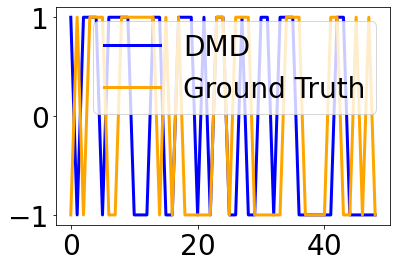

In [10]:
plt.plot(np.sign(dmdcoeff[:,0]), label='DMD',color='blue')
plt.plot(-np.sign(V_L_B[:,1]), label='Ground Truth',color='orange')
plt.legend()

In [11]:
accuracy

51.02040816326531

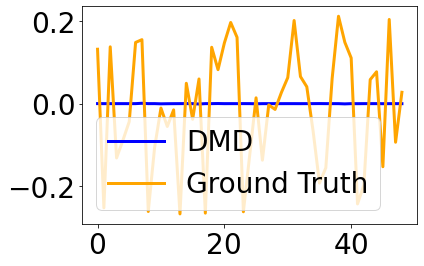

In [12]:
plt.plot(dmdcoeff[:,0], label='DMD',color='blue')
plt.plot(V_L_B[:,1], label='Ground Truth',color='orange')
plt.legend()

In [13]:
np.mean(dmdcoeff[:,0]-V_L_B[:,1])

0.009383817550521202

In [14]:
dmdcoeff[:,0]

array([ 7.69073722e-05, -5.21081964e-06,  4.56897699e-06,  9.02515125e-06,
        1.59898427e-05, -8.26916595e-06,  1.99022635e-05,  8.75519513e-04,
        4.83359005e-06,  5.31173460e-05, -4.44731850e-04, -1.81301803e-04,
       -6.63869131e-05,  3.02353636e-05,  1.21604055e-04, -6.13099724e-05,
       -8.29282705e-04,  1.97714314e-05,  2.12477516e-05,  2.61440609e-04,
       -2.02883521e-05,  3.07490919e-05, -3.85113993e-06,  6.94935188e-05,
        2.96743407e-05, -3.65630807e-04, -6.25903801e-06,  6.61768796e-06,
       -6.70326453e-06, -1.57714748e-05,  1.89586901e-05,  6.87321224e-06,
       -3.11328069e-05,  9.00729511e-06,  3.42812017e-05,  1.46650920e-04,
       -2.68484457e-06, -5.90822241e-06, -2.49364578e-05, -5.80595685e-04,
       -1.51407106e-05, -9.21998845e-05,  1.11674304e-05,  2.29617185e-05,
       -3.37719104e-07, -1.35435486e-04, -5.45368217e-05, -1.45071346e-05,
       -6.17480661e-05])